In [ ]:
#TODO: PCA



#TODO: This would be a cell where you can just plug in a filename and it will do everything in this notebook for you 
# We'll do this later... Once we flush out the preprocessing.

Step 1: Load EEG data

In [1]:
# Install
#!pip install mne
#!pip install pandas
#!pip install numpy

# For EEG
import mne

# For dataframes, graphs, and general stuff
import pandas as pd
import numpy as np

# For EEG
from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap

# For UTC and UNIX timezones (headache)
from datetime import datetime, timezone, timedelta
import pytz

# For something... I don't know this might be a typo.
import re

In [2]:
# This is just settings so that we can see the full DataFrame without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.expand_frame_repr', False)  # Don't wrap row

Creating RawArray with float64 data, n_channels=23, n_times=504527
    Range : 0 ... 504526 =      0.000 ...  1978.533 secs
Ready.
Using matplotlib as 2D backend.


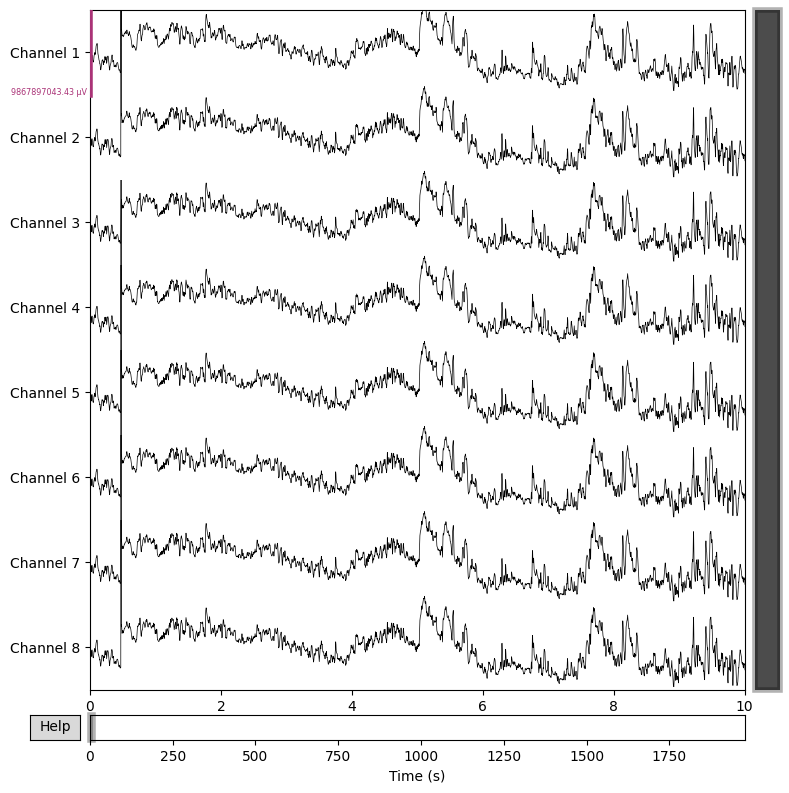

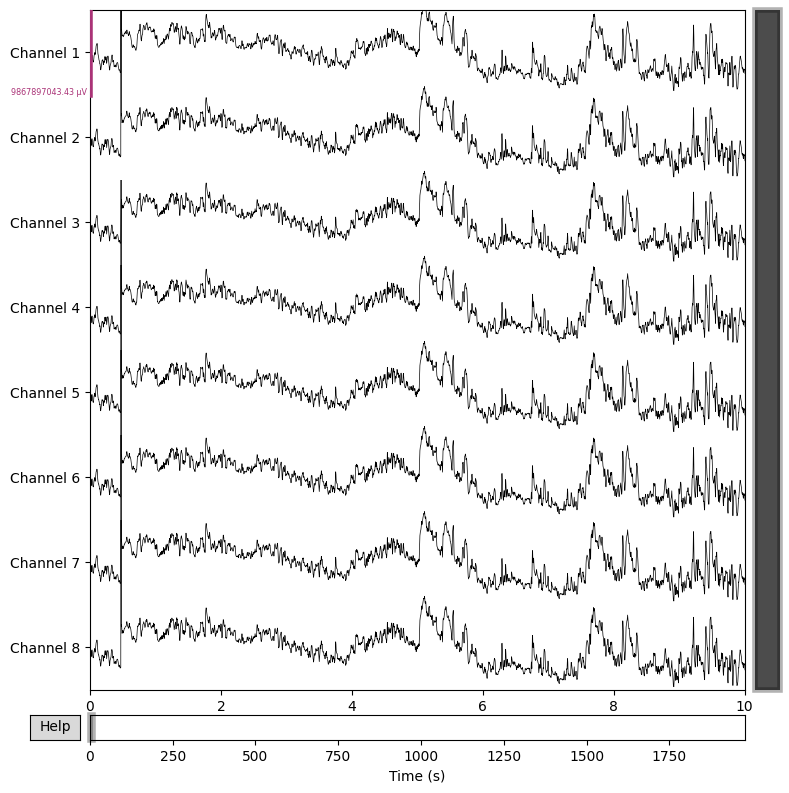

In [3]:
### Step 1. Load EEG Data ###

# Helper functions to convert from UNIX time to UTC time
# UNIX time is saved as an integer (seconds since 1/1/1970)
# UTC time is saved as a string ("YYYY-MM-DDTHH:MM:SSZ")
def unix_to_utc(unix_timestamp):
	utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
	local_timezone = pytz.timezone('America/Los_Angeles')
	local_time = utc_time.astimezone(local_timezone) # This gives our UTC time converted to PST
	return utc_time # This gives our raw UTC time
def utc_to_unix(utc_time_str):
    utc_time = datetime.strptime(utc_time_str, "%Y-%m-%dT%H:%M:%SZ")
    utc_time = utc_time.replace(tzinfo=timezone.utc)
    unix_timestamp = int(utc_time.timestamp())
    return unix_timestamp

# Function to load the data. Simply enter a file path
def load_eeg_data(file_path):

	# Create a dataframe from our data, replace NAs with 0s
	df = pd.read_csv(file_path, sep='\t', skiprows=2, header=None)
	df.fillna(0.0, inplace=True)

	# Extract EEG data
	trial_data = df.iloc[:, 1:24].values

	# Declares channel names and types of each set of data
	sfreq = 255  # sample rate in Hz
	ch_names = ['Channel {}'.format(i+1) for i in range(trial_data.shape[1])]
	ch_types = ['eeg' for i in range(trial_data.shape[1])]

	# Get the measurement date
	start_time_unix = trial_data[0][21] # This is where EEG start time is stored in UNIX time
	meas_date = unix_to_utc(start_time_unix) # However, MNE takes UTC time

	# Create info structures and RawArray objects for each set of data
	info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
	info.set_meas_date(meas_date)
	raw = mne.io.RawArray(trial_data.T, info)

	# Removing irrelevant channels
	ch_names = [raw.ch_names]
	ch_names_to_keep = [ch_names[0][0:8]]
	raw = raw.pick(ch_names_to_keep[0])

	# Now you can work with the MNE Raw object
	# print(raw.info)
	# raw.plot(scalings='auto')
	# raw.__len__()
	# More attributes here: https://mne.tools/1.8/generated/mne.io.RawArray.html

	# Return the RawArray object
	return raw

# Store our EEG data path in a variable
eeg_file_path_csv = '../raw_EEG_data/BrainFlow-RAW_2025-02-23_14-24-48_1.csv'

# Actual function call
raw = load_eeg_data(eeg_file_path_csv)

# Make a cool picture
raw.plot(scalings='auto')

Step 2: Load PsychoPy data

In [4]:
### Step 2.1 Load PsychoPy Data ###

# Helper function, converts PsychoPy's timestamp into UNIX
def psychopy_to_unix(psychopy_time):
    
    # Define the format of the input timestamp
    format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

    # Parse the custom timestamp into a datetime object
    parsed_timestamp = datetime.strptime(psychopy_time, format_string)

    # Convert the datetime object to a Unix timestamp (floating-point for microseconds)
    unix_timestamp = parsed_timestamp.timestamp()

    # Print the Unix timestamp
    return unix_timestamp

# Function to load psychopy data. Simply input the file path
def load_psychopy_data(file_path):

	# Read psychopy data into a pandas dataframe
	psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)
    
	#create a new column for the unix time of psychopy stimuli
	psychopy_df = psychopy_df.dropna(subset=["expStart"])
	psychopy_df["expStart"] = psychopy_df["expStart"].astype(str)
	psychopy_df["unix_time"] = psychopy_df["expStart"].apply(psychopy_to_unix)
    
	return psychopy_df

# Store our PsychoPy data in a variable
psyhcopy_file_path_csv = '../raw_PsychoPy_data/123_finaltest_2025-02-23_14h57.40.473.csv'

# Actual function call
psychopy_df = load_psychopy_data(psyhcopy_file_path_csv)

# Make sure it works
psychopy_df.head()

,symbols,amharic_set1,words_set1,amharic_set2,words_set2,amharic_set3,words_set3,amharic_set4,words_set4,amharic_practices,words_practice,image_practice,thisN,thisTrialN,thisRepN,debugging_press_enter_to_skip_24.keys,debugging_press_enter_to_skip_4.keys,debugging_press_enter_to_skip_5.keys,debugging_press_enter_to_skip_25.keys,key_resp_10.keys,key_resp_10.corr,key_resp_10.rt,key_resp_10.duration,debugging_press_enter_to_skip_23.keys,debugging_press_enter_to_skip_26.keys,debugging_press_enter_to_skip_15.keys,debugging_press_enter_to_skip_7.keys,debugging_press_enter_to_skip.keys,key_resp_5.keys,key_resp_5.corr,key_resp_5.rt,key_resp_5.duration,debugging_press_enter_to_skip_19.keys,debugging_press_enter_to_skip_9.keys,key_resp_6.keys,key_resp_6.corr,key_resp_6.rt,key_resp_6.duration,debugging_press_enter_to_skip_20.keys,debugging_press_enter_to_skip_11.keys,key_resp_7.keys,key_resp_7.corr,key_resp_7.rt,key_resp_7.duration,debugging_press_enter_to_skip_21.keys,debugging_press_enter_to_skip_13.keys,key_resp_8.keys,key_resp_8.corr,key_resp_8.rt,key_resp_8.duration,debugging_press_enter_to_skip_22.keys,answer_box.text,enter.keys,enter.rt,enter.duration,LoopParameters.thisRepN,LoopParameters.thisTrialN,LoopParameters.thisN,LoopParameters.thisIndex,pracitce_wrds.thisRepN,pracitce_wrds.thisTrialN,pracitce_wrds.thisN,pracitce_wrds.thisIndex,practice_sets1.thisRepN,practice_sets1.thisTrialN,practice_sets1.thisN,practice_sets1.thisIndex,practice_imagess.thisRepN,practice_imagess.thisTrialN,practice_imagess.thisN,practice_imagess.thisIndex,practice_sets2.thisRepN,practice_sets2.thisTrialN,practice_sets2.thisN,practice_sets2.thisIndex,practice_testt.thisRepN,practice_testt.thisTrialN,practice_testt.thisN,practice_testt.thisIndex,checkLoop.thisRepN,checkLoop.thisTrialN,checkLoop.thisN,checkLoop.thisIndex,xmarkLoop.thisRepN,xmarkLoop.thisTrialN,xmarkLoop.thisN,xmarkLoop.thisIndex,LearningSetOne.thisRepN,LearningSetOne.thisTrialN,LearningSetOne.thisN,LearningSetOne.thisIndex,setOne.thisRepN,setOne.thisTrialN,setOne.thisN,setOne.thisIndex,nreps_A1.thisRepN,nreps_A1.thisTrialN,nreps_A1.thisN,nreps_A1.thisIndex,nreps_B1.thisRepN,nreps_B1.thisTrialN,nreps_B1.thisN,nreps_B1.thisIndex,testSet1.thisRepN,testSet1.thisTrialN,testSet1.thisN,testSet1.thisIndex,checkloop.thisRepN,checkloop.thisTrialN,checkloop.thisN,checkloop.thisIndex,xloop.thisRepN,xloop.thisTrialN,xloop.thisN,xloop.thisIndex,LearningSetTwo.thisRepN,LearningSetTwo.thisTrialN,LearningSetTwo.thisN,LearningSetTwo.thisIndex,setTwo.thisRepN,setTwo.thisTrialN,setTwo.thisN,setTwo.thisIndex,nreps_A2.thisRepN,nreps_A2.thisTrialN,nreps_A2.thisN,nreps_A2.thisIndex,nreps_B2.thisRepN,nreps_B2.thisTrialN,nreps_B2.thisN,nreps_B2.thisIndex,testSet2.thisRepN,testSet2.thisTrialN,testSet2.thisN,testSet2.thisIndex,checkloop2.thisRepN,checkloop2.thisTrialN,checkloop2.thisN,checkloop2.thisIndex,xmark2.thisRepN,xmark2.thisTrialN,xmark2.thisN,xmark2.thisIndex,LearningSetThree.thisRepN,LearningSetThree.thisTrialN,LearningSetThree.thisN,LearningSetThree.thisIndex,setThree.thisRepN,setThree.thisTrialN,setThree.thisN,setThree.thisIndex,nreps_A3.thisRepN,nreps_A3.thisTrialN,nreps_A3.thisN,nreps_A3.thisIndex,nreps_B3.thisRepN,nreps_B3.thisTrialN,nreps_B3.thisN,nreps_B3.thisIndex,testSet3.thisRepN,testSet3.thisTrialN,testSet3.thisN,testSet3.thisIndex,checkloops3.thisRepN,checkloops3.thisTrialN,checkloops3.thisN,checkloops3.thisIndex,xmarkloops3.thisRepN,xmarkloops3.thisTrialN,xmarkloops3.thisN,xmarkloops3.thisIndex,LearningSetFour.thisRepN,LearningSetFour.thisTrialN,LearningSetFour.thisN,LearningSetFour.thisIndex,setFour.thisRepN,setFour.thisTrialN,setFour.thisN,setFour.thisIndex,nreps_A4.thisRepN,nreps_A4.thisTrialN,nreps_A4.thisN,nreps_A4.thisIndex,nreps_B4.thisRepN,nreps_B4.thisTrialN,nreps_B4.thisN,nreps_B4.thisIndex,testSet4.thisRepN,testSet4.thisTrialN,testSet4.thisN,testSet4.thisIndex,checkmark_loop4.thisRepN,checkmark_loop4.thisTrialN,checkmark_loop4.thisN,checkmark_loop4.thisIndex,xmark_loop4.thisRepN,xmark_

In [5]:
### Step 2.2 Get Annotations ###

def load_log_data(file_path):
	log_df = pd.read_csv(file_path, sep="\t", header=None, encoding="utf-8")
	log_df = log_df.rename(columns={0: "time", 1: "type", 2: "action"}) # Renames columns for easier access
	return log_df

# Saves log path as a variable
log_path = "../raw_PsychoPy_data/123_finaltest_2025-02-23_14h57.40.473.log"

# Create a dataframe of the log file
log_df = load_log_data(log_path)

# Here's the format of the log file
print(log_df.head())

      time      type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            action
0  79.4249     INFO                                                                                                                              

In [ ]:
# These are the action messages for different types of annotations
# Basically, whenever something shows up on the screen, it'll show these messages.
action_practice_training = ["practice_amharicc: autoDraw = True",
							"amharic_practice2: autoDraw = True"]
action_practice_testing = ["textAmharic_9: autoDraw = True"]
action_correctness = ["textCheck: text = '✓'", 
					  "textXmark: text = '✗'"]
action_training = ["amharics1: autoDraw = True", 
					"amharics1_2: autoDraw = True", 
					"amharics2: autoDraw = True", 
					"amharics2_2: autoDraw = True", 
					"amharics3: autoDraw = True", 
					"amharics3_2: autoDraw = True", 
				    "amharics4: autoDraw = True", 
				    "amharics4_2"]
action_testing = ["textAmharic_5: autoDraw = True", 
				"textAmharic_6: autoDraw = True", 
				"textAmharic_7: autoDraw = True", 
				"textAmharic_8: autoDraw = True"]

#make sure not to include practice data



In [7]:
# Extract only the rows in the log containing timestamps for when testing symbols appear.
# TODO: Potentially make one for the training symbols too?

# Creates a pattern and makes a sub-dataframe based on those filters
filtered_actions = action_practice_testing + action_testing + action_correctness
pattern = "|".join(filtered_actions)
sub_df = log_df[log_df["action"].str.contains(pattern, na=False, regex=True)]
sub_df.index = range(len(sub_df)) # Renaming row indices for easier iteration

# We filtered out all the actions in the log except for:
# 1) When amharic character shows up during a test
# 2) When a check/xmark shows up during a test
# Therefore, we will have: 
# (1 practice set * 6 questions) + (4 testing sets * 12 questions) total questions
# Since we have the question and a check/xmark, we should then have 120 total items in our sub-dataframe
print(len(sub_df))
print(sub_df)

120
          time  type                          action
0     280.3713  EXP   textAmharic_9: autoDraw = True
1     285.7719  EXP            textXmark: text = '✗'
2     287.3244  EXP   textAmharic_9: autoDraw = True
3     294.2870  EXP            textXmark: text = '✗'
4     295.8433  EXP   textAmharic_9: autoDraw = True
5     300.9280  EXP            textCheck: text = '✓'
6     302.4755  EXP   textAmharic_9: autoDraw = True
7     309.0383  EXP            textCheck: text = '✓'
8     310.5813  EXP   textAmharic_9: autoDraw = True
9     316.2907  EXP            textCheck: text = '✓'
10    317.8546  EXP   textAmharic_9: autoDraw = True
11    323.8231  EXP            textXmark: text = '✗'
12    325.3636  EXP   textAmharic_9: autoDraw = True
13    330.6071  EXP            textCheck: text = '✓'
14    332.1376  EXP   textAmharic_9: autoDraw = True
15    336.9257  EXP            textCheck: text = '✓'
16    338.4545  EXP   textAmharic_9: autoDraw = True
17    343.9418  EXP            textCheck: 

In [8]:
# Create a list of timestamps 
# The list will be ordered chronologically
# Each element will have the format (timestamp, correct/incorrect)
testing_timestamps = []

# Iterating through every 2 rows
# This assumes that characters show up in even indices (0, 2, 4, ...)
# And correctness show up in odd indices (1, 3, 5, ...)
for index in range(0, len(sub_df), 2):
	timestamp, correctness = float(sub_df["time"][index]), sub_df["action"][index+1][-2]
	testing_timestamps.append((timestamp, correctness))

# If this happened correctly, testing_timestamps should be half the size of sub_df
#print(len(testing_timestamps) == len(sub_df)/2)

sub_df.head()

,time,type,action
0,280.3713,EXP,textAmharic_9: autoDraw = True
1,285.7719,EXP,textXmark: text = '✗'
2,287.3244,EXP,textAmharic_9: autoDraw = True
3,294.2870,EXP,textXmark: text = '✗'
4,295.8433,EXP,textAmharic_9: autoDraw = True


In [9]:

# make a list of onsets
# list of durations
# tags for all of them
#    potential tags:
#       for test phases: 
#         ->  symbol_blank: when symbol first comes on screen, right vs wrong*
#         ->  symbol_real_answer: when the real answer appears on screen
#         ->  symbol_fake_answer: when the incorrect answers appear
#             wrong_button: when the participant selects the wrong wrong_button
#             correct_button: when the particpant selects the right wrong_button
# ->: these are the most important ones 
# *a challenge for this is going to be identifying symbol_blank that led to right answers vs wrong ones
#      need to make this distinction because this the N400 should only be present for right answers


###  1. make a list of onsets   ####
#  make a list for each tag, where the list is comprised of the time at which they showed up

# drop action column
#sub_df=sub_df.drop('type', axis=1)

def extract_rows(df, check_symbol="✓"):
    """
    Extract rows where the 'action' contains 'textAmharic' and the next row's 'action'
    contains the specified check symbol.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        check_symbol (str): The symbol to look for in the next row's action.
        
    Returns:
        learned_list (list): List of rows (as pd.Series) that meet the criteria.
    """
    list = []
    # Loop through all rows except the last (since we check the next row)
    for i in range(len(df) - 1):
        current_action = df.iloc[i]["action"]
        next_action = df.iloc[i + 1]["action"]
        
        if "textAmharic" in current_action and check_symbol in next_action:
            list.append(df.iloc[i]["time"])
    
    return list

learned_list = extract_rows(sub_df, check_symbol="✓")
not_learned_list = extract_rows(sub_df, check_symbol="✗")

# lists are a bunch of np.float64, convert these all to standard floats
def np_float_to_float(np_float64_list):
    new_list = []

    for i in range(0,len(np_float64_list)):
        new_list.append(float(np_float64_list[i]))
    
    return new_list


# now we have lists of just the times
learned_list_times = np_float_to_float(learned_list)
not_learned_list_times = np_float_to_float(not_learned_list)



### 2. list of durations ###
# just needs to be a list filled with 1 since the duration is a second
duration = 1
length = len(learned_list_times) + len(not_learned_list_times)

duration_list = [duration] * length

# this should be 60, for now, remember we're getting 12 values from the practice set 
#print(len(duration_list))


### 3. tags for all of them ###
# make a list for learned that's filled with the tag "learned" and as long as the length is for learned_times

learned_tags = ["learned"] * len(learned_list_times)
not_learned_tags = ["not_learned"] * len(not_learned_list_times)

# this should also be 60
# print(len(learned_tags) + len(not_learned_tags))



###    4. finally combine the various lists to get their final form  ###
# make sure that not_learned gets added BEHIND learned. so list looks like
#   learned, learned, learned, not_learned, not_learned etc.
#   this also applies to the tags

# combine times for onsets
final_onsets = learned_list_times + not_learned_list_times
#print(len(not_learned_list_times))

# combine tags
final_description = learned_tags + not_learned_tags


In [10]:
# EEG recordings start before the PsychoPy recordings
# Create orig_time for the annotations. This should be where the annotations (in seconds) will consider "0"
# The buffer repreesnts the time in between the two
# This should be calculated in UNIX because it's easier
buffer = psychopy_df.loc[0, 'unix_time'] - utc_to_unix(raw.info['meas_date'].strftime("%Y-%m-%dT%H:%M:%SZ"))
new_orig_time = (raw.info['meas_date'] + timedelta(seconds=buffer)).strftime("%Y-%m-%d %H:%M:%S.%f")

# Create a list of onsets
symbol_onsets = [timestamp for timestamp, correctness in testing_timestamps]


# Create annotations
# later_annot = mne.Annotations(
#     onset=symbol_onsets,                    					# A list of onsets, in second (after new_orig_time??), when stimuli was shown.
#     duration=[1 for _ in range(len(symbol_onsets))],            # How long each symbol lasted
#     description=["symbol" for _ in range(len(symbol_onsets))],  # Names for the stimuli TODO: make list of symbols in the order they appeared
#     orig_time=new_orig_time,            						# Syncs PsychoPy start time and OpenBCI start time
# )

# by Aaron
later_annot = mne.Annotations(
    onset = final_onsets,
    duration = duration_list,
    description = final_description,
    orig_time=new_orig_time,
)

# Set annotations
raw = raw.copy().set_annotations(later_annot)

EEG data time range: 0 to 1978.5333333333333 seconds
Annotations in raw2: <Annotations | 60 segments: learned (54), not_learned (6)>
Adjusted onsets: [ 404.11279  411.06589  419.58479  426.21699  434.32279  441.59609
  449.10509  455.87909  462.19599  469.21389  475.93719  482.42849
  725.56639  732.69669  739.69539  746.13819  752.83949  759.88179
  766.17179  772.65249  779.14779  788.19249  794.54339  801.32129
 1073.59969 1080.01569 1086.51379 1093.22989 1102.36329 1108.98389
 1115.48549 1122.19749 1128.73489 1135.50179 1142.09199 1150.92899
 1431.27849 1439.51489 1445.83699 1452.89659 1459.25569 1465.67799
 1472.84949 1483.98499 1490.67389 1497.47379 1504.00779 1512.91899
 1785.92969 1792.58619 1798.95539 1805.61739 1812.21839 1819.15859
 1826.09369 1832.53089 1839.07099 1847.76579 1854.55599 1860.91479]


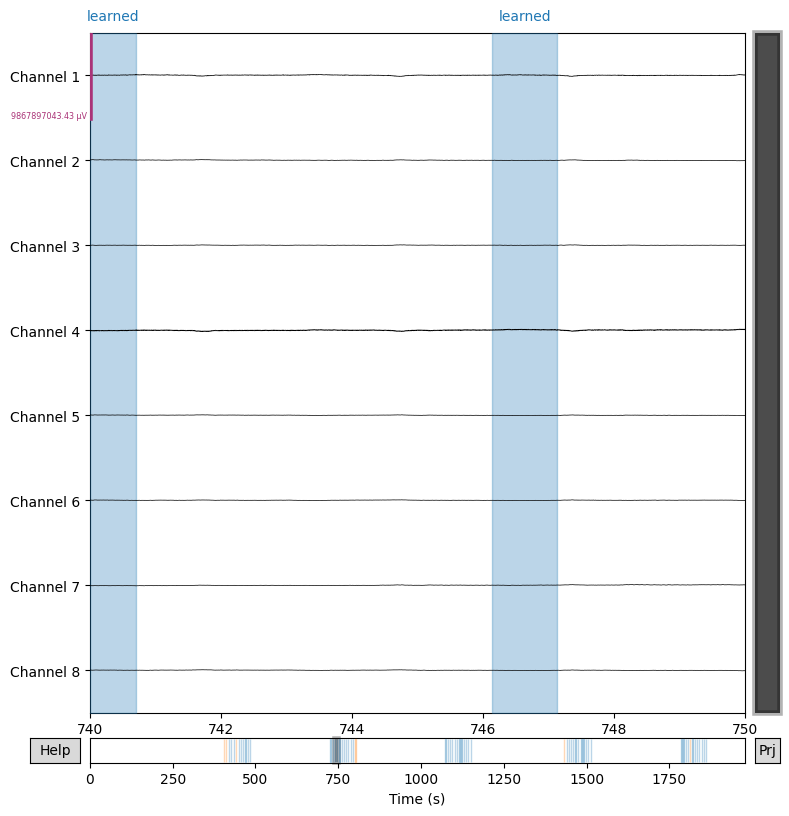

EEG channel type selected for re-referencing


C:\Users\cheng\AppData\Local\Temp\ipykernel_21160\2796234051.py:6: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference(projection=True)  #dont worry


<RawArray | 8 x 504527 (1978.5 s), ~30.8 MiB, data loaded>

In [14]:
#debugging
print("EEG data time range: 0 to", raw.times[-1], "seconds")  #how long the experiment was in seconds
print("Annotations in raw2:", raw.annotations)               #list of the annotations
print("Adjusted onsets:", raw.annotations.onset)             #the adjusted onsets
raw.plot(start=740, duration=10, scalings='auto', block=True)  # Adjust start and duration as needed
raw.set_eeg_reference(projection=True)  #dont worry

Step 2.5: Filtering... Hopefully this will make it better

In [15]:
#setting high and low band pass filter
f_low = 0.1
f_high = 30
data_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
#low and high pass filter, fir_design can be changed to match what lit review did

#notch filter for electrical noise
data_cleaned.notch_filter(60)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)



Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1683 samples (6.600 s)



<RawArray | 8 x 504527 (1978.5 s), ~30.8 MiB, data loaded>

Effective window size : 8.031 (s)
Plotting power spectral density (dB=True).


C:\Users\cheng\AppData\Local\Temp\ipykernel_21160\191288221.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_cleaned.compute_psd(fmin=0,fmax=50).plot()
c:\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


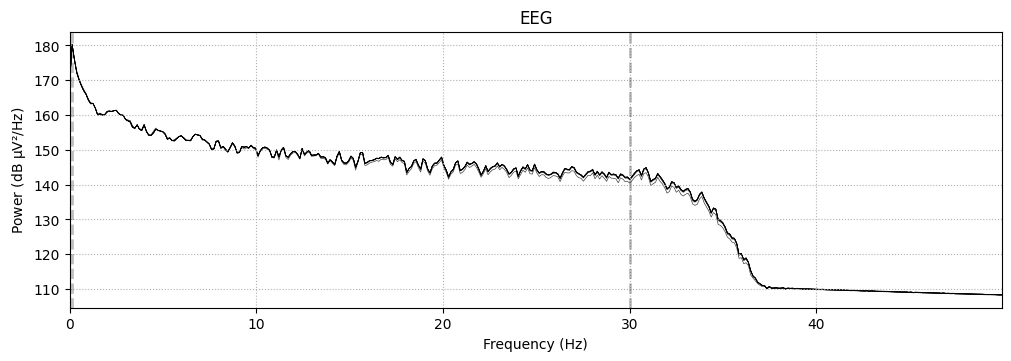

In [16]:
#new plot
data_cleaned.compute_psd(fmin=0,fmax=50).plot()

Selecting Non noisy data

In [17]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  
#pass in our raw file with all our eeg files
#exclude "bads" discards what signal are identified as bad. 
  #this does a lot of work for us

Artifact removal with ICA

In [18]:
#TO - DO: determine how many components there are, use 8 for now
ica = ICA(n_components=8, random_state=97, method="fastica")

ica.fit(data_cleaned)   
#raw cleaned has been through filtering
#clean will have gone through ica

data_cleaned = ica.apply(data_cleaned)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 4.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


Step 3: Create an ERP averaging of the annotations

Used Annotations descriptions: [np.str_('learned'), np.str_('not_learned')]
Not setting metadata
60 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 60 events and 307 original time points ...
0 bad epochs dropped
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


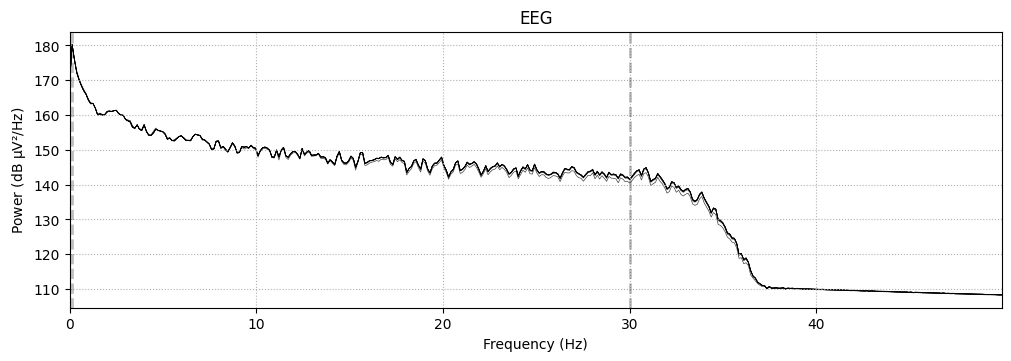

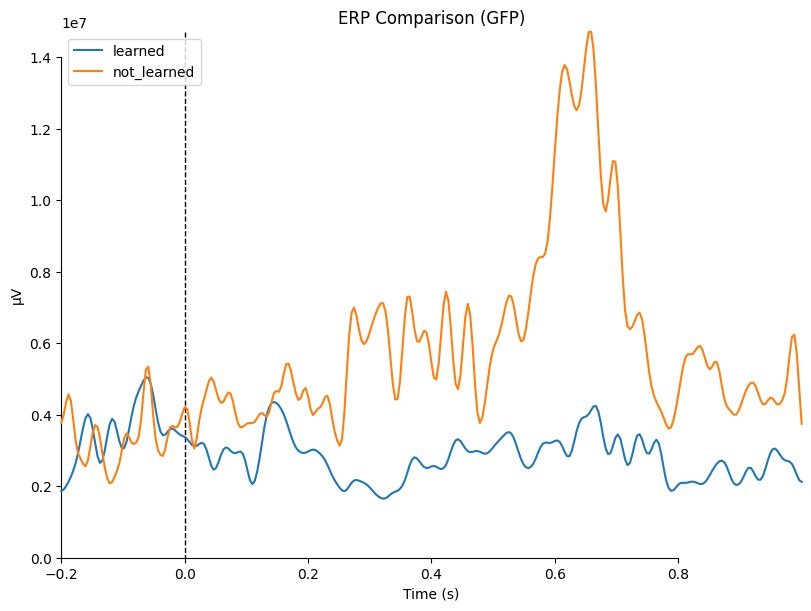

[<Figure size 800x600 with 1 Axes>]

In [19]:
# Extract events from annotations
events, event_id = mne.events_from_annotations(data_cleaned)

# Define the epoch time window (start and end in seconds relative to event onset)
tmin, tmax = -0.2, 1  # for example, 200ms before and 500ms after each event

# Create epochs
epochs = mne.Epochs(
    data_cleaned,                # Variable that contains our data
    events,                      # Events we want to investigate, remember we changed T1 and T2 to this
    event_id,
	tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

# Compute the average ERP for each event type
evoked_dict = {event: epochs[event].average() for event in event_id}

# Plot the ERPs
mne.viz.plot_compare_evokeds(evoked_dict, picks='eeg', title='ERP Comparison')


Notes: Ngl, this doesn't look very N400-like.....
* But some possible explanations:
   * Perhaps it does look N400 like once we compare it to our controls (i.e. seeing a character for the first time)
   * Otherwise, its probably something to do with the way we annotated our data, maybe our units?
   * One last consideration is the way we recorded the data; were we too close too the computer maybe? This looks a bit high in microvolts for ERP